<a href="https://colab.research.google.com/github/VCMI-handson/200822/blob/master/Hands_on_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

![대체 텍스트](https://drive.google.com/uc?export=view&id=1C_0gHRwgYOxWxZfcdzUTbJymACw801s2)

[출처](https://medium.com/zylapp/review-of-deep-learning-algorithms-for-object-detection-c1f3d437b852)


# Step 0. 실습환경 셋팅

접속 링크 입력

# Step 1. 데이터셋 불러들이기

##Lung segmentation from Chest X-Ray dataset

https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

![대체 텍스트](https://drive.google.com/uc?export=view&id=1Oa-iXD9IMQre4Ao7CyslObAtZRBCskvB)
![대체 텍스트](https://drive.google.com/uc?export=view&id=1lz6EHChnPtCbkH6XI_Tm0_tEpJWnkb1a)
![대체 텍스트](https://drive.google.com/uc?export=view&id=1ZK09wg_gJGGCyKnvkSkgxcpl1Pz4esDa)


###Lung_Segmentation.zip
###256x256x3
###566 datasets [image, label]

In [ ]:
!rm -rf *
!wget https://github.com/mi2rl/datasets/raw/master/Lung_Segmentation.zip

In [ ]:
!ls

In [ ]:
!unzip Lung_Segmentation.zip

In [ ]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "./Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)
#print(file_headers)

X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

count = 0
for fh in file_headers:
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))
    
    img = imread(f1)[:,:,:IMG_CHANNELS]
    mask = imread(l1)
    mask = np.expand_dims(mask, axis=-1)

    X_all[count] = img
    y_all[count] = mask
    
    count += 1

**딥러닝을 위한 데이터 전처리**

In [ ]:
X_all = X_all.astype('float32') / 255.
y_all = y_all.astype('float32') / 255.

**학습, 검증, 테스트 데이터 셋으로 분리**

In [ ]:
# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

# Step 2. 데이터 살펴보기

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]), 'gray')
        plt.axis('off')
        plt.show()
        
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

# Step 3. VGG16 네트워크 다시보기

![대체 텍스트](https://drive.google.com/uc?export=view&id=18lsu_m-_kn2Is69N11KYzUUFCYzj6i_i)

In [ ]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, BatchNormalization
from keras.models import Model

def vgg16():
    inputs = Input(shape=(256, 256, 3,), name="VGGInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation='relu')(pool_5)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    pred = Dense(1000, activation='softmax')(x)
        
    return Model(inputs=inputs, outputs=pred)

# Step 4. 첫번째 영상분할 모델 (FCN32s)

![대체 텍스트](https://drive.google.com/uc?export=view&id=13hnpVhEYBHXytLoBQ7R19zvaHBGLEiou)

In [ ]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Activation, Conv2DTranspose, BatchNormalization
from keras import optimizers
from keras.models import Model
from keras.optimizers import *

def fcn32s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
        
    conv_t1 = UpSampling2D(size = (32,32))(pool_5)    
    conv_t2 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv_t1)
    
    pred = Activation('sigmoid')(conv_t2)
    
    return Model(inputs=inputs, outputs=pred)

**loss 계산**

In [ ]:
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

**생성한 모델 수행**

In [ ]:
# build the model
model = fcn32s()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy'])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=1, verbose=1)
model.save('fcn-32s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-1.0, -0.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

**결과 확인**

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN     

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()
    
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    preds_valid_t = (preds_valid > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_valid")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_valid")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_valid_t[0][:,:,0], 'gray')
    plt.show()
    
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 2ms/step - loss: -0.5514 - accuracy: 0.8385


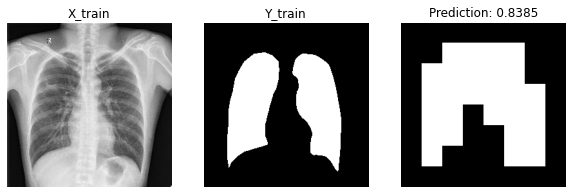

1/1 [==============================] - 0s 2ms/step - loss: -0.4690 - accuracy: 0.8439


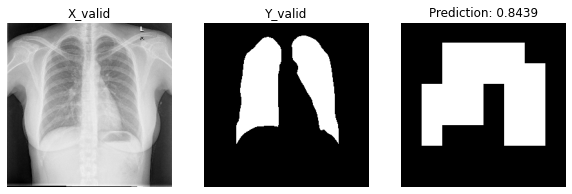

1/1 [==============================] - 0s 2ms/step - loss: -0.5751 - accuracy: 0.8962


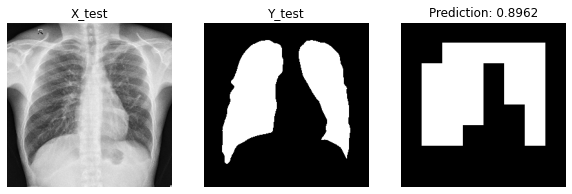

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

# Step 5.  두번째 영상분할 모델 (FCN8s)

**Skip Connection**

![대체 텍스트](https://drive.google.com/uc?export=view&id=1m7zNPxTiDMqYEmcNm35020vTUhJXkWRY)

In [1]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, BatchNormalization
from keras.models import Model

def fcn8s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #fcn32s
    #conv_t1 = UpSampling2D(size = (32,32))(pool_5)    
    #conv_t2 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv_t1)
    #pred = Activation('sigmoid')(conv_t2)
    
    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)
    
    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)     
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])
   
    conv_t3 = UpSampling2D(size = (8,8))(fuse_2)
    
    pred = Activation('sigmoid')(conv_t3)
    
    return Model(inputs=inputs, outputs=pred)

**생성한 모델 수행**

In [2]:
# build the model
model = fcn8s()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy'])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=1, verbose=1)
model.save('fcn-8s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-1.0, -0.5])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

NameError: ignored

**결과 확인**

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

# Step 6. 두번째 영상분할 모델 개선 (FCN2s)

**Skip Connection**

In [ ]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, Activation, BatchNormalization
from keras.models import Model
from keras.optimizers import *

def fcn2s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)

    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)    
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])
  
    #(64, 64)
    score_pool2 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_2)
    conv_t3 = UpSampling2D(size = (2,2))(fuse_2)
    fuse_3 = Add()([conv_t3,score_pool2])

    #(128, 128)
    score_pool1 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_1)
    conv_t4 = UpSampling2D(size = (2,2))(fuse_3)
    fuse_4 = Add()([conv_t4,score_pool1])
      
    conv_t5 = UpSampling2D(size = (2,2))(fuse_4)
    
    pred = Activation('sigmoid')(conv_t5)
    
    return Model(inputs=inputs, outputs=pred)

**생성한 모델 수행**

In [ ]:
# build the model
model = fcn2s()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy'])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-2s.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-1.0, -0.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

결과 확인

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

# Step 7. 두번째 영상분할 모델 개선 (FCN8s with Deconvolution)

Deconvolution

![대체 텍스트](https://drive.google.com/uc?export=view&id=1lo8xBRyU_FWrlsNsRMklaPa8h6nc7DMJ)

In [ ]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import *

def fcn8s_deconv():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)
    
    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)
 
    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    
    conv_t1 = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2), padding="same")(conv8)
    conv_t1 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t1)
    conv_t1 = BatchNormalization()(conv_t1)
    conv_t1 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t1)
    conv_t1 = BatchNormalization()(conv_t1)
    
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    
    conv_t2 = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2),padding="same")(fuse_1)
    conv_t2 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t2)
    conv_t2 = BatchNormalization()(conv_t2)
    conv_t2 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t2)
    conv_t2 = BatchNormalization()(conv_t2)
    
    fuse_2 = Add()([conv_t2,score_pool3])

    #(32, 32) x 8 = 256
    conv_t3 = Conv2DTranspose(1, kernel_size=(8,8), strides=(8,8), padding="same")(fuse_2)
    conv_t3 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t3)
    conv_t3 = BatchNormalization()(conv_t3)
    conv_t3 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t3)
    conv_t3 = BatchNormalization()(conv_t3)
    
    pred = Activation('sigmoid')(conv_t3)
    
    return Model(inputs=inputs, outputs=pred)

**생성한 모델 수행**

In [ ]:
# build the model
model = fcn8s_deconv()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy'])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('fcn-8s_deconv.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-1.0, -0.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

**결과 확인**

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

# Step 8. 세번째 영상분할 모델 (Unet)

![대체 텍스트](https://drive.google.com/uc?export=view&id=1vSx_i5kIBjaHTk5pvaa-yOXTX_69UzZh)

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

**생성한 모델 수행**

In [ ]:
# build the model
model = unet()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy'])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=8, verbose=1)
model.save('unet.h5')

# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-1.0, -0.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

**결과 확인**

In [ ]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)